In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [102]:
import requests
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from geopy.distance import vincenty, distance
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import reverse_geocoder as rg 
import pprint 
import gmplot

In [ ]:
with open(r"final_data.pickle", "rb") as input_file:
    data = pickle.load(input_file)

## Analysing the data

#### Analysing the distribution of nodes across various classifications/tags.

In [4]:
def plot_bar(x_val, y_val):
    index = np.arange(len(x_val))
    plt.bar(index, y_val)
    plt.xticks(index, x_val, fontsize=11, rotation=90)
    plt.show()

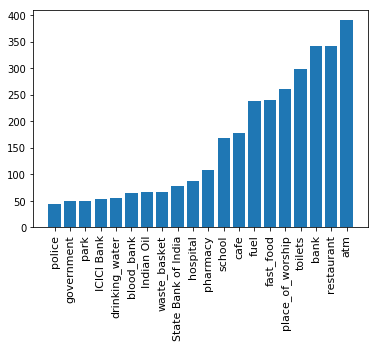

In [5]:
classification_quantity = {}
for node in data:
    for attr in node[2].keys():
        if node[2][attr] not in classification_quantity.keys():
            classification_quantity[node[2][attr]] = 1
        else:
            classification_quantity[node[2][attr]] += 1
            
sorted_list = (sorted(classification_quantity.items(), key = lambda kv:(kv[1], kv[0]))) # creating a sorted list of tags:number of nodes sorted on number of nodes    

            
classification = []
quantity = []

# classification_quantity
for obj in sorted_list:
    quantity.append(obj[1])
    classification.append(obj[0])
    
plot_bar(classification[-20:], quantity[-20:])

In [6]:
df = pd.DataFrame(data, columns = ['lat', 'lon', 'tags'])
df.head()

,lat,lon,tags
0,28.533492,77.151895,"{'amenity': 'cafe', 'name': 'Cafe Coffee Day'}"
1,28.533647,77.152001,"{'amenity': 'bank', 'name': 'ICICI, SBI, Citib..."
2,28.508450,77.166546,"{'amenity': 'school', 'name': 'Heritage Intern..."
3,28.511716,77.163482,"{'amenity': 'school', 'name': 'Deep Public Sch..."
4,28.505700,77.175677,"{'amenity': 'place_of_worship', 'name': 'Temple'}"


In [7]:
print(len(df), len(data))

3982 3982


#### Visualizing the spatial distribution of the nodes on a scatter plot where X-axis is the longitude and Y-axis is the latitude.

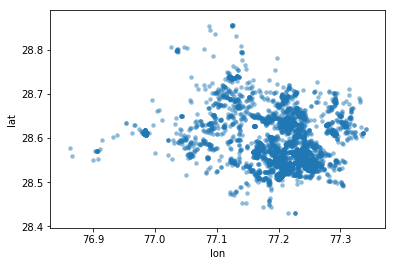

In [41]:
df = df.sort_values(by=['lat', 'lon'])
ax = df.plot(kind='scatter', x='lon', y='lat', alpha=0.5, linewidth=0)

In [88]:
coords_df = df.filter(['lat', 'lon'], axis=1)
coords = coords_df.values
kms_per_radian = 6371.0088
epsilon = 0.5/kms_per_radian

## Clustering using the DBSCAN (Density-Based Spatial Clustering of Applications with Noise) Algorithm

1) eps - The maximum distance between two samples for one to be considered as in the neighborhood of the other.

2) min_samples - The number of samples in a neighborhood for a point to be considered as a core point.

3) haversine metric - The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.

In [89]:
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='auto', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
unique_labels = set(cluster_labels)
num_clusters = len(set(cluster_labels))
print(num_clusters) # number of clusters formed by the algorithm

46


### Visualizing the clusters in the spaital plain using a scatter plot

The gray colored points are not part of any cluster and have been marked as outlier/noise by the algorithm

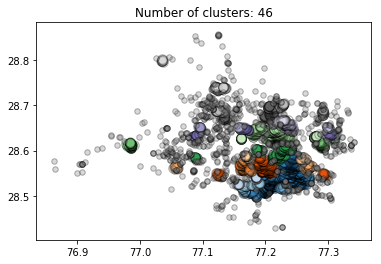

In [124]:
fig, ax = plt.subplots()
colors = plt.cm.tab20c(np.linspace(0, 1, num_clusters)) # list of colors for marking different clusters in the scatter plot

# Each cluster (point with same label) is represented by a different color on the scatter plot 

for cluster_label, color in zip(unique_labels, colors):    
    size = 90
    if cluster_label == -1: 
        color = 'gray'
        size = 30
    x_coords = coords[cluster_labels==cluster_label][:,1]
    y_coords = coords[cluster_labels==cluster_label][:,0]
    ax.scatter(x=x_coords, y=y_coords, c=[color], edgecolor='black', s=size, alpha=0.3)

ax.set_title('Number of clusters: {}'.format(num_clusters))
plt.show()

### A Bar Plot showing the number of nodes in each cluster

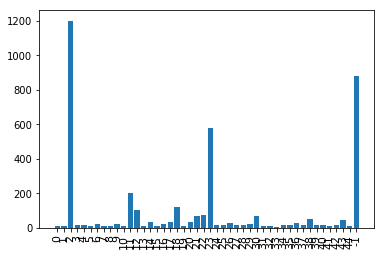

In [91]:
num_nodes = []
for cluster_label in unique_labels:
    num_nodes.append(len(coords[cluster_labels==cluster_label][:,1]))
plot_bar(unique_labels, num_nodes)

In [92]:
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
clusters.tail()
clusters = clusters[:-1]
clusters.tail()

40    [[28.6836786, 77.1358422], [28.6838443, 77.130...
41    [[28.6869377, 77.1222176], [28.6882438, 77.121...
42    [[28.6960233, 77.223917], [28.6965167, 77.2270...
43    [[28.7325136, 77.1186337], [28.7342137, 77.124...
44    [[28.7946905, 77.0372885], [28.7979343, 77.034...
dtype: object

## Finding the point closest to the center for each cluster

#### Each Center point represents a separate market or commercial center in New Delhi

In [93]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
representative_points = pd.DataFrame({'lat':lats, 'lon':lons})
print(representative_points)
representative_points.to_csv('markets.csv')

          lat        lon
0   28.500181  77.184280
1   28.507109  77.176490
2   28.543607  77.227716
3   28.510203  77.167626
4   28.516169  77.227032
5   28.521758  77.166746
6   28.524822  77.185335
7   28.526270  77.156165
8   28.540346  77.184788
9   28.546461  77.124875
10  28.548062  77.292951
11  28.565705  77.196416
12  28.567285  77.165603
13  28.555959  77.175334
14  28.562903  77.268575
15  28.563725  77.057422
16  28.580717  77.258581
17  28.587510  77.169274
18  28.596840  77.225363
19  28.585754  77.088375
20  28.602108  77.187316
21  28.611947  77.288760
22  28.612620  76.984990
23  28.633742  77.216291
24  28.627811  77.307965
25  28.626527  77.160986
26  28.631282  77.279125
27  28.633317  77.089946
28  28.634851  77.303550
29  28.646576  77.167197
30  28.652464  77.233705
31  28.648281  77.096341
32  28.650629  77.299216
33  28.651086  77.157443
34  28.664340  77.214598
35  28.667342  77.230346
36  28.671262  77.134209
37  28.673190  77.200290
38  28.689878  77.209890


### Visualizing the center point for each cluster using scatter plot

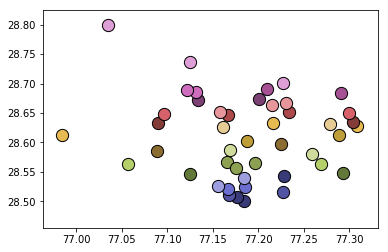

In [94]:
coords_rep = representative_points.values
x_rep = coords_rep[:,1]
y_rep = coords_rep[:,0]

fig, ax = plt.subplots()
colors = plt.cm.tab20b(np.linspace(0, 1, len(x_rep)))

for x_coor, y_coor, color in zip(x_rep, y_rep, colors):
    ax.scatter(x=x_coor, y=y_coor, c=[color], edgecolor='black', s=150, alpha=1)

plt.show()

## Visualizing the commercial centers (center point for each cluster) identified after clustering on actual map of New Delhi

In [122]:
min_lat, max_lat, min_lon, max_lon = min(representative_points['lat']), max(representative_points['lat']), min(representative_points['lon']), max(representative_points['lon'])
mymap = gmplot.GoogleMapPlotter(min_lat + (max_lat - min_lat) / 2, min_lon + (max_lon - min_lon) / 2, 13)
mymap.heatmap( y_rep, x_rep) 
mymap.draw( "map_delhi.html" ) 

## Using Reverse Geocoding for visualizing and verifying our results

When we use reverse geocoding on all the points with the same label, we find that all the points represent the same location in New Delhi which verifies the results of our clustering algorithm

The following cells show results for 2 labels selected at random.

In [95]:
def reverseGeocode(coordinates): 
    result = rg.search(coordinates) 
#     pprint.pprint(result)
    return result

In [96]:
for cluster_label in list(unique_labels)[9:]:    
    if cluster_label != -1: 
        lats = coords[cluster_labels==cluster_label][:,1]
        lons = coords[cluster_labels==cluster_label][:,0]
        for lat, lon in zip(lats, lons):
            print('latitude: '+str(lat), 'longitude: '+str(lon))
            print(reverseGeocode((lon,lat)))
            print('***************************************')
        break

latitude: 77.1289089 longitude: 28.542241
[OrderedDict([('lat', '28.65156'), ('lon', '77.18859'), ('name', 'Karol Bagh'), ('admin1', 'NCT'), ('admin2', 'Central Delhi'), ('cc', 'IN')])]
***************************************
latitude: 77.1286516 longitude: 28.5429566
[OrderedDict([('lat', '28.65156'), ('lon', '77.18859'), ('name', 'Karol Bagh'), ('admin1', 'NCT'), ('admin2', 'Central Delhi'), ('cc', 'IN')])]
***************************************
latitude: 77.1285737 longitude: 28.5432647
[OrderedDict([('lat', '28.65156'), ('lon', '77.18859'), ('name', 'Karol Bagh'), ('admin1', 'NCT'), ('admin2', 'Central Delhi'), ('cc', 'IN')])]
***************************************
latitude: 77.1283049 longitude: 28.5440893
[OrderedDict([('lat', '28.65156'), ('lon', '77.18859'), ('name', 'Karol Bagh'), ('admin1', 'NCT'), ('admin2', 'Central Delhi'), ('cc', 'IN')])]
***************************************
latitude: 77.128262 longitude: 28.5441966
[OrderedDict([('lat', '28.65156'), ('lon', '77.1885

In [97]:
for cluster_label in list(unique_labels)[22:]:    
    if cluster_label != -1: 
        lats = coords[cluster_labels==cluster_label][:,1]
        lons = coords[cluster_labels==cluster_label][:,0]
        for lat, lon in zip(lats, lons):
            print('latitude: '+str(lat), 'longitude: '+str(lon))
            print(reverseGeocode((lon,lat)))
            print('***************************************')
        break

latitude: 76.985117 longitude: 28.6060798
[OrderedDict([('lat', '28.69108'), ('lon', '76.9316'), ('name', 'Bahadurgarh'), ('admin1', 'Haryana'), ('admin2', 'Jhajjar'), ('cc', 'IN')])]
***************************************
latitude: 76.9861294 longitude: 28.6064169
[OrderedDict([('lat', '28.69108'), ('lon', '76.9316'), ('name', 'Bahadurgarh'), ('admin1', 'Haryana'), ('admin2', 'Jhajjar'), ('cc', 'IN')])]
***************************************
latitude: 76.9861241 longitude: 28.6064404
[OrderedDict([('lat', '28.69108'), ('lon', '76.9316'), ('name', 'Bahadurgarh'), ('admin1', 'Haryana'), ('admin2', 'Jhajjar'), ('cc', 'IN')])]
***************************************
latitude: 76.9860785 longitude: 28.6065299
[OrderedDict([('lat', '28.69108'), ('lon', '76.9316'), ('name', 'Bahadurgarh'), ('admin1', 'Haryana'), ('admin2', 'Jhajjar'), ('cc', 'IN')])]
***************************************
latitude: 76.9860677 longitude: 28.6065605
[OrderedDict([('lat', '28.69108'), ('lon', '76.9316'), ('n

[OrderedDict([('lat', '28.69108'), ('lon', '76.9316'), ('name', 'Bahadurgarh'), ('admin1', 'Haryana'), ('admin2', 'Jhajjar'), ('cc', 'IN')])]
***************************************
latitude: 76.9878833 longitude: 28.6126342
[OrderedDict([('lat', '28.69108'), ('lon', '76.9316'), ('name', 'Bahadurgarh'), ('admin1', 'Haryana'), ('admin2', 'Jhajjar'), ('cc', 'IN')])]
***************************************
latitude: 76.9796548 longitude: 28.6126726
[OrderedDict([('lat', '28.69108'), ('lon', '76.9316'), ('name', 'Bahadurgarh'), ('admin1', 'Haryana'), ('admin2', 'Jhajjar'), ('cc', 'IN')])]
***************************************
latitude: 76.9861953 longitude: 28.6126819
[OrderedDict([('lat', '28.69108'), ('lon', '76.9316'), ('name', 'Bahadurgarh'), ('admin1', 'Haryana'), ('admin2', 'Jhajjar'), ('cc', 'IN')])]
***************************************
latitude: 76.9864054 longitude: 28.612799
[OrderedDict([('lat', '28.69108'), ('lon', '76.9316'), ('name', 'Bahadurgarh'), ('admin1', 'Haryana')

### Saving the results

In [98]:
latitudes_list = coords[:,0]
longitudes_list = coords[:,1]
df = pd.DataFrame({'lat':latitudes_list, 'lon':longitudes_list, 'labels':cluster_labels})
df.head()

,lat,lon,labels
0,28.429265,77.215275,-1
1,28.430043,77.226110,-1
2,28.430217,77.226130,-1
3,28.430836,77.226680,-1
4,28.443195,77.174650,-1


In [99]:
df.labels.unique()

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 12, 14, 15,
       16, 18, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 29, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], dtype=int64)

In [100]:
df.to_csv('clustered_data.csv')